In [1]:
using Base.Iterators
using LinearAlgebra
using Plots

### Define problem

In [2]:
energy = 100 # dimensions
H2O = 16
mission = 5
state_dimensions = [energy, H2O, mission]
grid_world3D = zeros(energy, H2O, mission) # 3D grid world in energy, H2O, mission progress
p_mission_regression = 0.05
p_power_fail = 0.02
p_water_loss = 0.02
energy_per_day = 2 #energy production per day

2

### Generate actions

In [3]:
actions = []
#for i in -3:3
    #for j in -3:3
       # for k in 0:3
            #if abs(i) + abs(j) + abs(k) <= 3 # Max action 1-norm distance of 3
            #    if k == 0 || (k != 0 && (i <= 0 && j <= 0 && i + j < 0) && k == -i - j) # If no mission progress OR mission progress equal to resources expended
            #        action = [i, j, k]
            #        push!(actions, action)
               # end
          #  end
       # end
  #  end

#end

#get oxygen

#make mission progress
actions = push!(actions, [-4, -2, 1])
#make water
actions = push!(actions, [-2, 1, 0])

#do nothing
push!(actions, [0, 0, 0])

print(actions)

Any[[-4, -2, 1], [-2, 1, 0], [0, 0, 0]]

In [4]:
function Reward_Model(state)
    if (state[3] == state_dimensions[3])
        return 1000
    else
        return float(-(state[1])/10 - float(state[2])/16)
    end
end    

#reward model in full matrix form
#reward_model = similar(grid_world3D)
#for i in 1:state_dimensions[1], j in 1:state_dimensions[2], k in 1:state_dimensions[3]
#if (k == state_dimensions[3])
 #   reward_model[i, j, k] = 1000
#else
  #  reward_model[i, j, k] = float(i)/10 + float(j)/16
#end
#end    

Reward_Model (generic function with 1 method)

In [5]:
#transition model
N_SS = state_dimensions[1]*state_dimensions[2]*state_dimensions[3]
function Transition_Model(current_state, action, state_dimension)
    if (is_in_grid(current_state, [energy_per_day,0,0], state_dimension))
        current_state[1] = current_state[1] + energy_per_day #produce some energy every day
    end
    x = rand()
    if (x < 0.05)
        next_state = current_state # no progress
    elseif (x < p_water_loss)
        current_state[2] = 0.0 # lose all energy
        next_state = current_state + action
    elseif (x<(p_water_loss + p_power_fail))
        current_state[1] = 0.0 # lose all water
        next_state = current_state + action
    elseif (x < (p_mission_regression + p_water_loss + p_power_fail) && current_state[3] >= 1)
        current_state[3] = current_state[3] - 1 #backwards progress mission
        next_state = current_state + action
    else 
        next_state = current_state + action
    end
    reward = Reward_Model(next_state)
    return next_state, reward
end

Transition_Model (generic function with 1 method)

In [6]:
function find_valid_action(current_state, actions, state_dimension)
    valid_action = false
    current_state_temp = current_state
    while (valid_action == false)
        
        idx = rand(1:length(actions))
        action = actions[idx]

        if (is_in_grid(current_state, action, state_dimension))
            current_state, reward = Transition_Model(current_state, action, state_dimension)
            valid_action = true
            return action, current_state, reward
        end
    end
end

function is_in_grid(state, action, state_dimension)
    for i in 1:length(state)
        if ((state[i] + action[i]) < 1 || (state[i] + action[i]) > state_dimension[i])
            return false
        end
    end
    return true
end

current_state = [1,1,1]
states = current_state
rewards = [0.0]
for i in 1:200
    action, current_state, reward = find_valid_action(current_state, actions, state_dimensions)
    append!(states, current_state)
    append!(rewards, reward)
    if(current_state[3] == state_dimensions[3])
        break
    end
end
states = reshape(states, (3, Int(length(states)/3)))

3×33 Matrix{Int64}:
 3  3  3  3  5  3  5  5  7  9  9  9  9  …  17  19  19  21  21  21  23  25  23
 1  1  2  3  3  1  1  2  2  2  3  4  5      1   1   2   2   3   4   4   4   2
 1  1  1  1  1  2  2  2  2  2  1  1  1      4   4   4   4   4   4   4   4   5

In [7]:
#prepare to plot

mission = states[3,:]
resources_E = states[1, :]
resources_H2O = states[2,:]
resources_total = resources_E  + resources_H2O
goal = fill(mission[end], length(mission))
t = range(0, length=length(mission))
rewards_accumulation = cumsum(rewards)


33-element Vector{Float64}:
   0.0
  -0.3625
  -0.7875
  -1.275
  -1.9625
  -2.3249999999999997
  -2.8874999999999997
  -3.5124999999999997
  -4.3374999999999995
  -5.362499999999999
   ⋮
 -22.8375
 -24.799999999999997
 -26.824999999999996
 -29.049999999999997
 -31.3375
 -33.6875
 -36.2375
 -38.9875
 961.0125

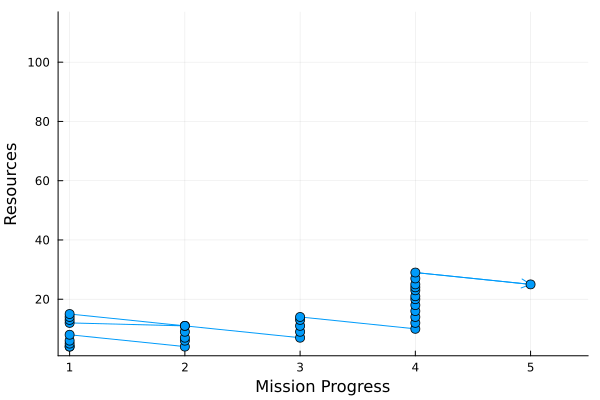

In [8]:
#plot Mission Progress over Resources
p1 = plot()
plot!(p1, mission, resources_total, marker=(:circle,5), arrow=true, arrowsize=0.1, legend=false)
vline!(p1, goal[1])
ylabel!("Resources")
xlabel!("Mission Progress")
ylims!(0.9, (state_dimensions[1] + state_dimensions[2] + 1))
xlims!(0.9, state_dimensions[3] + 0.5)

#savefig(p1, "Mission Progress VS Resources.pdf")

┌ Info: Saved animation to /var/folders/53/dkwtw9r94vvbm2k2b5khb0ch0000gn/T/jl_xezy1qbEpQ.gif
└ @ Plots /Users/Anna/.julia/packages/Plots/sxUvK/src/animation.jl:156


Plots.AnimatedGif("/var/folders/53/dkwtw9r94vvbm2k2b5khb0ch0000gn/T/jl_xezy1qbEpQ.gif")
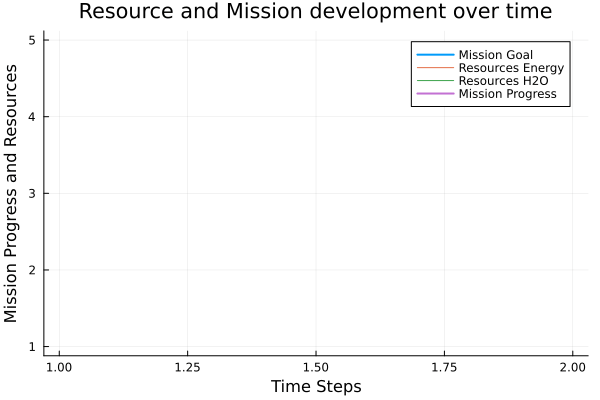

In [9]:
#plot Mission and Resource development over time
#savefig(p2, "Mission Progress VS Resources.pdf")
anim = @animate for i in 1:length(mission)
    p2 = plot()
    plot!(p2 , 1:i, goal[1:i],  linewidth=2,   label="Mission Goal")
    plot!(p2 ,1:i, [resources_E[1:i], resources_H2O[1:i]], label=["Resources Energy" "Resources H2O"], title = "Resource and Mission development over time")
    plot!(p2 ,1:i, mission[1:i], linewidth = 2,  label="Mission Progress")
    xlabel!("Time Steps")
    ylabel!("Mission Progress and Resources")
end


gif(anim, fps=5)

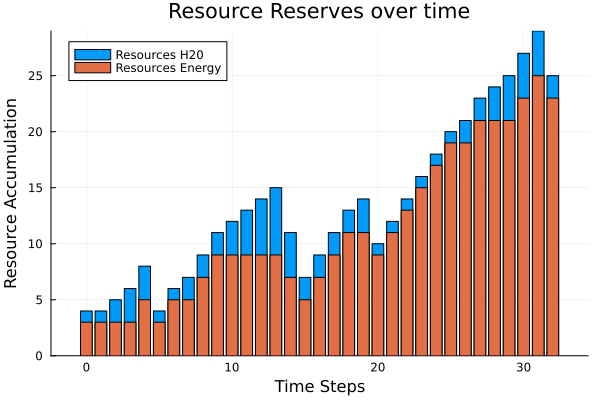

In [10]:
#Resource level histogram
p3 = bar(t, [resources_total, resources_E], xlabel="Time Steps", ylabel="Resource Accumulation", label=["Resources H20" "Resources Energy"], title = "Resource Reserves over time")

#savefig(p3, "Resource Reserves.pdf")

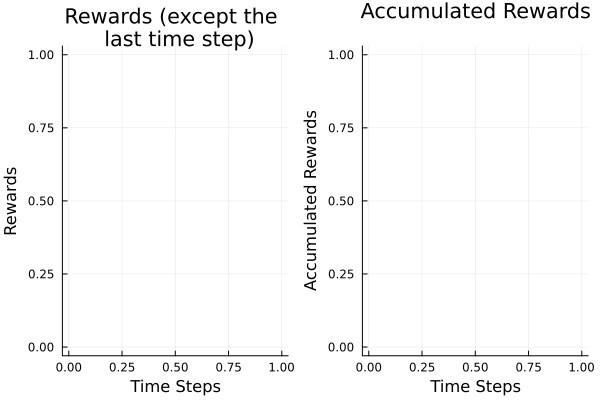

In [31]:
#Plot Reward accumulation over time
layout = @layout [a b] #creates 1x2 subplots

p4 = plot(t[1:end-1], rewards[1:end-1], subplot=1, layout=layout,legend=false)
plot!(p4, t, rewards_accumulation, subplot=2, legend=false)
xlabel!(p4, "Time Steps")
ylabel!(p4, "Rewards", subplot=1)
ylabel!(p4, "Accumulated Rewards", subplot=2)
title!(p4,"Rewards (except the \n last time step)", subplot = 1)
title!(p4,"Accumulated Rewards", subplot = 2)

#savefig(p4, "Rewards.pdf")